# Data Preparation


### Import Libraries

In [98]:
import numpy as np
import pandas as pd
import os
import json

### Load Data

In [2]:
pd.set_option('display.max_colwidth', -1)

In [138]:
dirs = ["biorxiv_medrxiv", "comm_use_subset", "noncomm_use_subset", "pmc_custom_license"]
paper_dict = []

print("Loading data...")
for d in dirs:
    for i, file in enumerate(os.listdir(f"data/{d}/{d}/")):
        file_path = f"data/{d}/{d}/{file}"
        j = json.load(open(file_path, "rb"))
        for ref in j["bib_entries"]:
            paper_dict.append([j["paper_id"], j["bib_entries"][ref]["title"]])
print("Finished")

Loading data...
Finished


### Prepare dataset

In [143]:
paper_df = pd.DataFrame(data=paper_dict, columns=["paper_id", "cite"])

# Clean dataset
filter1 = ~paper_df["cite"].str.contains("copyright")
filter2 = ~paper_df["cite"].str.contains("rights reserved")
paper_df = paper_df[np.logical_and(filter1,filter2)].reset_index(drop=True)

# Select papers only that are cited more than 20 times
paper_count = paper_df.groupby("cite").count().sort_values("paper_id",).reset_index()
paper_count_restr = paper_count[paper_count["paper_id"]>20]
paper_df_restr = paper_df[paper_df["cite"].isin(paper_count_restr["cite"])]
paper_df_restr = paper_df_restr.set_index("paper_id")

# Onehot encoding
paper_df_onehot = pd.get_dummies(paper_df_restr["cite"])
paper_df_onehot = paper_df_onehot.reset_index().groupby("paper_id").sum().reset_index()
paper_df_onehot.shape

(8047, 827)

# Analysis
In this part we are using classification algorithms to create clusters.

### Import Libraries

In [144]:
from sklearn.cluster import DBSCAN

In [145]:
X = paper_df_onehot.loc[:, paper_df_onehot.columns != "paper_id"]
db = DBSCAN(eps=1, min_samples=2).fit(X)
db.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

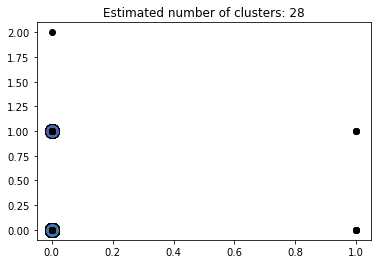

In [136]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
      
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()